In [123]:
import datetime
import sklearn
import random
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV


In [124]:
data = pd.read_csv('synthetic_data.csv')

data['time_start'] = pd.to_datetime(data['time_start'])


def assign_date(row):
    if row['day_of_the_week'] == 'Monday':
        return '2024-09-01'  # Date for Mondays
    elif row['day_of_the_week'] == 'Tuesday':
        return '2024-09-02'  # Date for Tuesdays
    elif row['day_of_the_week'] == 'Wednesday':
        return '2024-09-03'  # Date for Wednesdays
    elif row['day_of_the_week'] == 'Thursday':
        return '2024-09-04'  # Date for Thursdays
    elif row['day_of_the_week'] == 'Friday':
        return '2024-09-05'  # Date for Fridays
    elif row['day_of_the_week'] == 'Saturday':
        return '2024-09-06'  # Date for Saturday
    else:
        return '2024-09-07' 

# Apply the function to create a new date column
data['new_date'] = data.apply(assign_date, axis=1)

# Combine the new date with the existing time
data['time_start'] = data.apply(lambda x: pd.to_datetime(f"{x['new_date']} {x['time_start'].strftime('%H:%M:%S')}"), axis=1)

# Now apply rounding to the nearest minute
data['time_start'] = data['time_start'].dt.round('1min')

data = data.drop(columns=['role', 'frequency_of_travel','primary_purpose', 'travel_days', 'travel_hours', 'not_able_to_get_on', 'additional_features_frequency', 'additional_features_seats',
                          'additional_features_cleanliness', 'additional_features_comfortable', 'additional_features_route_coverage', 'additional_features_updates',
                          'issues_with_quality_of_info', 'special_events', 'seasonal_changes'])

data

C:\Users\enqil\AppData\Local\Temp\ipykernel_32576\1460915050.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['time_start'] = pd.to_datetime(data['time_start'])


,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,...,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness,is_valid,new_date
0,A2,Opp University Hall,Ventus,Friday,2024-09-05 09:30:00,15 - 20 minutes,2,5,4,5,...,5,4,3,4,6,5,2,1,True,2024-09-05
1,D2,KR MRT,UTown,Thursday,2024-09-04 09:30:00,10 - 15 minutes,4,3,4,3,...,4,5,1,4,6,5,3,2,True,2024-09-04
2,A2,UHC,S17,Thursday,2024-09-04 17:50:00,< 5 minutes,2,4,4,3,...,4,5,1,2,3,5,4,6,True,2024-09-04
3,A1,PGP Terminal,Opp UHC,Sunday,2024-09-07 11:30:00,10 - 15 minutes,4,4,4,4,...,5,4,3,2,6,4,5,1,True,2024-09-07
4,A1,KR MRT,LT27,Friday,2024-09-05 07:50:00,< 5 minutes,4,3,4,4,...,5,4,1,3,6,4,5,2,True,2024-09-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55845,K,KR MRT,CLB,Friday,2024-09-05 09:24:00,5 - 10 minutes,2,3,4,2,...,4,5,1,4,6,5,3,2,True,2024-09-05
55846,A1,KR MRT,CLB,Sunday,2024-09-07 18:50:00,10 - 15 minutes,1,4,4,5,...,4,5,1,4,3,6,5,2,True,2024-09-07
55847,A1,LT13,KR MRT,Friday,2024-09-05 11:42:00,5 - 10 minutes,2,4,5,3,...,5,3,1,4,5,3,6,2,True,2024-09-05
55848,A2,Opp YIH,S17,Tuesday,2024-09-02 11:46:00,< 5 minutes,4,4,4,5,...,4,5,1,3,6,5,2,4,True,2024-09-02


In [125]:

## Grouping data

grouped_data = data.groupby(['ISB_Service', 'bus_stop_board', 'time_start', 'day_of_the_week']).agg(
    count=('ISB_Service', 'size')  # Get count for each group
    
)

grouped_data = grouped_data.sort_values(by='time_start')

# Reset the index if needed to make it easier to work with
grouped_data = grouped_data.reset_index()


# Display the grouped and aggregated data
grouped_data

,ISB_Service,bus_stop_board,time_start,day_of_the_week,count
0,D2,KR MRT,2024-09-01 07:45:00,Monday,2
1,A1,BIZ2,2024-09-01 07:46:00,Monday,1
2,D2,Opp KR MRT,2024-09-01 07:46:00,Monday,4
3,A1,YIH,2024-09-01 07:46:00,Monday,4
4,A1,PGP Terminal,2024-09-01 07:46:00,Monday,3
...,...,...,...,...,...
19084,K,KR MRT,2024-09-07 20:46:00,Sunday,2
19085,A2,IT,2024-09-07 20:46:00,Sunday,2
19086,A1,KR MRT,2024-09-07 20:46:00,Sunday,2
19087,BTC (Bukit Timah Campus),KR MRT,2024-09-07 20:46:00,Sunday,2


In [126]:
def assign_weekend(row):
    if row['day_of_the_week'] == 'Saturday':
        return 1
    elif row['day_of_the_week'] == 'Sunday':
        return 1
    else:
        return 0 


def assign_peak(row):
    hour = row['time_start'].hour
    minute = row['time_start'].minute
    # Define peak timings 
    if (9 <= hour <= 18) and (30 <= minute <= 59):
        return 1  # Peak timing
    else:
        return 0  # Non-peak timing 


def assign_hour(row):
    hour = row['time_start'].hour
    return hour  


def assign_minute(row):
    minute = row['time_start'].minute
    return minute 


grouped_data['is_weekend'] = grouped_data.apply(assign_weekend, axis=1)
grouped_data['is_peak'] = grouped_data.apply(assign_peak, axis=1)
grouped_data['hour'] = grouped_data.apply(assign_hour, axis=1)
grouped_data['minute'] = grouped_data.apply(assign_minute, axis=1)


#grouped_data = grouped_data.drop('time_start', axis=1)
count = grouped_data.pop('count')
grouped_data.insert(0, 'count', count)



grouped_data


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute
0,2,D2,KR MRT,2024-09-01 07:45:00,Monday,0,0,7,45
1,1,A1,BIZ2,2024-09-01 07:46:00,Monday,0,0,7,46
2,4,D2,Opp KR MRT,2024-09-01 07:46:00,Monday,0,0,7,46
3,4,A1,YIH,2024-09-01 07:46:00,Monday,0,0,7,46
4,3,A1,PGP Terminal,2024-09-01 07:46:00,Monday,0,0,7,46
...,...,...,...,...,...,...,...,...,...
19084,2,K,KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46
19085,2,A2,IT,2024-09-07 20:46:00,Sunday,1,0,20,46
19086,2,A1,KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46
19087,2,BTC (Bukit Timah Campus),KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46


In [127]:
## Splitting dataset
label_encoder_bsb = preprocessing.LabelEncoder() 
label_encoder_ISBS = preprocessing.LabelEncoder() 
label_encoder_dotw = preprocessing.LabelEncoder()


buses = ['A1', 'A2', 'D1', 'D2', 'BTC (Bukit Timah Campus)', 'E', 'K', 'L']
train_main = pd.DataFrame()
test_main = pd.DataFrame()

random.seed(99)

def random_split(bus):
    bus_data = grouped_data[(grouped_data['ISB_Service'] == bus)]
    
    # Check if bus_data is not empty to avoid issues
    if len(bus_data) == 0:
        return pd.DataFrame(), pd.DataFrame()
    
    n = len(bus_data)

    shuffled_bus = bus_data.sample(n, random_state = 99) 
    shuffled_bus = shuffled_bus.reset_index(drop=True)

    ## Split dataset to 70% (train) and 30% (split)
    x = round(n*0.7)
    train_df, test_df = shuffled_bus[1:x], shuffled_bus[x:]
    return train_df, test_df

# Loop over each bus service and split the data
for bus in buses:
    train_df, test_df = random_split(bus)
    
    # Append each split to the main train and test DataFrames
    train_main = pd.concat([train_main, train_df], ignore_index=True)
    test_main = pd.concat([test_main, test_df], ignore_index=True)

# Encode labels in column 'ISB_Service', 'bus_stop_board'. 
test_main['bus_stop_board']= label_encoder_bsb.fit_transform(test_main['bus_stop_board']) 
train_main['bus_stop_board']= label_encoder_bsb.fit_transform(train_main['bus_stop_board'])  
 
test_main['day_of_the_week']= label_encoder_dotw.fit_transform(test_main['day_of_the_week']) 
train_main['day_of_the_week']= label_encoder_dotw.fit_transform(train_main['day_of_the_week']) 

train_main['ISB_Service']= label_encoder_ISBS.fit_transform(train_main['ISB_Service'])
test_main['ISB_Service']= label_encoder_ISBS.fit_transform(test_main['ISB_Service'])



In [128]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Sort by sequence for time series 
train_main = train_main.sort_values(by='time_start')
train_main = train_main.reset_index()
train_main = train_main.drop('index', axis=1)
train_df = pd.concat([train_main, train_df], ignore_index=True)
train_main = train_main.drop('time_start', axis=1)

test_main = test_main.sort_values(by='time_start')
test_main = test_main.reset_index()
test_main = test_main.drop('index', axis=1)
test_df = pd.concat([test_main, test_df], ignore_index=True)
test_main = test_main.drop('time_start', axis=1)

print(train_main.shape)
print(test_main.shape)
test_df




(13355, 8)
(5727, 8)


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute
0,6,4,3,2024-09-01 07:46:00,1,0,0,7,46
1,2,6,8,2024-09-01 07:46:00,1,0,0,7,46
2,1,2,8,2024-09-01 07:46:00,1,0,0,7,46
3,4,1,4,2024-09-01 07:46:00,1,0,0,7,46
4,17,0,6,2024-09-01 07:46:00,1,0,0,7,46
...,...,...,...,...,...,...,...,...,...
5722,1,0,0,2024-09-07 20:46:00,3,1,0,20,46
5723,3,4,3,2024-09-07 20:46:00,3,1,0,20,46
5724,1,3,9,2024-09-07 20:46:00,3,1,0,20,46
5725,1,1,15,2024-09-07 20:46:00,3,1,0,20,46


In [129]:
# Scaling data to avoid prediction errors
scaler = MinMaxScaler(feature_range=(0,1))
train_main_scaled = scaler.fit_transform(train_main)
test_main_scaled = scaler.transform(test_main)

train_main_scaled

array([[0.0028169 , 0.8       , 0.26086957, ..., 0.        , 0.        ,
        0.76271186],
       [0.0028169 , 1.        , 0.52173913, ..., 0.        , 0.        ,
        0.77966102],
       [0.        , 0.2       , 0.52173913, ..., 0.        , 0.        ,
        0.77966102],
       ...,
       [0.        , 0.6       , 0.86956522, ..., 0.        , 1.        ,
        0.77966102],
       [0.0028169 , 0.2       , 0.17391304, ..., 0.        , 1.        ,
        0.77966102],
       [0.0028169 , 1.        , 0.26086957, ..., 0.        , 1.        ,
        0.77966102]])

In [130]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY(train_main_scaled,30)
testX, testY = createXY(test_main_scaled,30)


testX_backup, testY_backup = testX, testY ### maybe remove

print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

print(trainX.shape[1],trainX.shape[2])

print(testY)
testX_backup.shape

(13325, 30, 8)
(13325,)
(5697, 30, 8)
(5697,)
30 8
[0.01971831 0.02253521 0.0084507  ... 0.         0.         0.        ]


(5697, 30, 8)

### Finding the best parameters

Initialize KerasRegressor with no fixed parameters
grid_model = KerasRegressor(build_fn=build_model, verbose=1)

parameters = {
    'batch_size': [16, 20],
    'epochs': [8, 10],
    'optimizer': ['adam', 'Adadelta']
}


grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(trainX, trainY, validation_data=(testX, testY))


grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

my_model = grid_search.best_estimator_

In [131]:
def build_model(optimizer='adam'):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True, input_shape=(30, 8)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss='mse', optimizer=optimizer)
    return grid_model

best_model = KerasRegressor(build_fn = build_model,
                                 batch_size = 16,
                                 epochs = 8,
                                 optimizer = 'adam',
                                 verbose = 1 )

# Fit the model with the training data
best_model.fit(trainX, trainY, validation_data=(testX, testY))

Epoch 1/8


c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


833/833 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0018 - val_loss: 4.5921e-04
Epoch 2/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 8.0110e-04 - val_loss: 4.4648e-04
Epoch 3/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 7.6108e-04 - val_loss: 4.5285e-04
Epoch 4/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.0011 - val_loss: 4.4896e-04
Epoch 5/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 6.9144e-04 - val_loss: 4.4515e-04
Epoch 6/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 0.0010 - val_loss: 4.4955e-04
Epoch 7/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 9.0574e-04 - val_loss: 4.4683e-04
Epoch 8/8
833/833 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 7.0464e-04 - val_loss: 4.4535e-04


KerasRegressor(
	model=None
	build_fn=<function build_model at 0x0000023CABAF25F0>
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=8
)

In [132]:
prediction = best_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
prediction
 [0.00252874 0.00341262 0.00504719 ... 0.00361375 0.00362102 0.00376731]

Prediction Shape- (5697,)


In [133]:
prediction_copies_array = np.tile(prediction[:, np.newaxis], (1, 8))

print(prediction_copies_array.shape)
prediction_copies_array

(5697, 8)


array([[0.00252874, 0.00252874, 0.00252874, ..., 0.00252874, 0.00252874,
        0.00252874],
       [0.00341262, 0.00341262, 0.00341262, ..., 0.00341262, 0.00341262,
        0.00341262],
       [0.00504719, 0.00504719, 0.00504719, ..., 0.00504719, 0.00504719,
        0.00504719],
       ...,
       [0.00361375, 0.00361375, 0.00361375, ..., 0.00361375, 0.00361375,
        0.00361375],
       [0.00362102, 0.00362102, 0.00362102, ..., 0.00362102, 0.00362102,
        0.00362102],
       [0.00376731, 0.00376731, 0.00376731, ..., 0.00376731, 0.00376731,
        0.00376731]], dtype=float32)

In [134]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),8)))[:,0]

pred

array([1.8977029, 2.2114804, 2.7917511, ..., 2.2828825, 2.2854636,
       2.3373957], dtype=float32)

In [135]:
original_copies_array = np.repeat(testY,8, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),8)))[:,0]

df = test_df.iloc[30:].reset_index(drop=True)
df['predicted_count'] = pred

print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)
df

Pred Values--  [1.8977029 2.2114804 2.7917511 ... 2.2828825 2.2854636 2.3373957]

Original Values--  [8. 9. 4. ... 1. 1. 1.]


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
0,8,2,6,2024-09-01 08:46:00,1,0,0,8,46,1.897703
1,9,4,8,2024-09-01 08:46:00,1,0,0,8,46,2.211480
2,4,6,6,2024-09-01 08:46:00,1,0,0,8,46,2.791751
3,1,4,21,2024-09-01 08:46:00,1,0,0,8,46,3.190922
4,1,6,17,2024-09-01 08:46:00,1,0,0,8,46,3.430980
...,...,...,...,...,...,...,...,...,...,...
5692,1,0,0,2024-09-07 20:46:00,3,1,0,20,46,2.622379
5693,3,4,3,2024-09-07 20:46:00,3,1,0,20,46,2.341386
5694,1,3,9,2024-09-07 20:46:00,3,1,0,20,46,2.282882
5695,1,1,15,2024-09-07 20:46:00,3,1,0,20,46,2.285464


In [136]:
# Reverse label encoding for train_main

df['ISB_Service'] = df['ISB_Service'].astype(int)
df['day_of_the_week'] = df['day_of_the_week'].astype(int)
df['bus_stop_board'] = df['bus_stop_board'].astype(int)
df['ISB_Service'] = label_encoder_ISBS.inverse_transform(df['ISB_Service'])
df['bus_stop_board'] = label_encoder_bsb.inverse_transform(df['bus_stop_board'])
df['day_of_the_week'] = label_encoder_dotw.inverse_transform(df['day_of_the_week'])

df

,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
0,8,BTC (Bukit Timah Campus),KR MRT,2024-09-01 08:46:00,Monday,0,0,8,46,1.897703
1,9,D2,LT27,2024-09-01 08:46:00,Monday,0,0,8,46,2.211480
2,4,K,KR MRT,2024-09-01 08:46:00,Monday,0,0,8,46,2.791751
3,1,D2,University Hall,2024-09-01 08:46:00,Monday,0,0,8,46,3.190922
4,1,K,PGP Terminal,2024-09-01 08:46:00,Monday,0,0,8,46,3.430980
...,...,...,...,...,...,...,...,...,...,...
5692,1,A1,BIZ2,2024-09-07 20:46:00,Sunday,1,0,20,46,2.622379
5693,3,D2,COM3,2024-09-07 20:46:00,Sunday,1,0,20,46,2.341386
5694,1,D1,Museum,2024-09-07 20:46:00,Sunday,1,0,20,46,2.282882
5695,1,A2,Opp YIH,2024-09-07 20:46:00,Sunday,1,0,20,46,2.285464


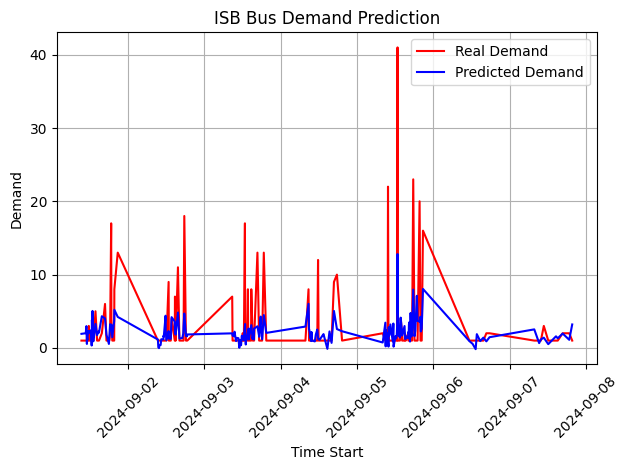

MAE: 1.9314906586138976
MAPE: 0.8994894227879258


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
43,1,A2,Opp KR MRT,2024-09-01 09:21:00,Monday,0,0,9,21,1.921331
142,1,A2,Opp KR MRT,2024-09-01 10:42:00,Monday,0,1,10,42,2.004096
156,1,A2,Opp KR MRT,2024-09-01 10:55:00,Monday,0,1,10,55,2.973047
167,1,A2,Opp KR MRT,2024-09-01 11:04:00,Monday,0,0,11,4,0.545180
172,2,A2,Opp KR MRT,2024-09-01 11:07:00,Monday,0,0,11,7,1.413820
...,...,...,...,...,...,...,...,...,...,...
5559,1,A2,Opp KR MRT,2024-09-07 14:36:00,Sunday,1,1,14,36,1.582845
5579,1,A2,Opp KR MRT,2024-09-07 15:09:00,Sunday,1,0,15,9,1.314798
5616,2,A2,Opp KR MRT,2024-09-07 16:42:00,Sunday,1,1,16,42,1.963664
5669,2,A2,Opp KR MRT,2024-09-07 18:46:00,Sunday,1,1,18,46,1.106286


In [137]:
a2 = df[(df['ISB_Service'] == 'A2')]
a2_Opp_KR_MRT = a2[(a2['bus_stop_board'] == 'Opp KR MRT')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(a2_Opp_KR_MRT['time_start'], a2_Opp_KR_MRT['count'], color='red', label='Real Demand')
plt.plot(a2_Opp_KR_MRT['time_start'], a2_Opp_KR_MRT['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae_a2 = mean_absolute_error(a2_Opp_KR_MRT['count'], a2_Opp_KR_MRT['predicted_count'])
mape_a2 = mean_absolute_percentage_error(a2_Opp_KR_MRT['count'], a2_Opp_KR_MRT['predicted_count'])

print("MAE:", mae_a2)
print("MAPE:", mape_a2)

a2_Opp_KR_MRT

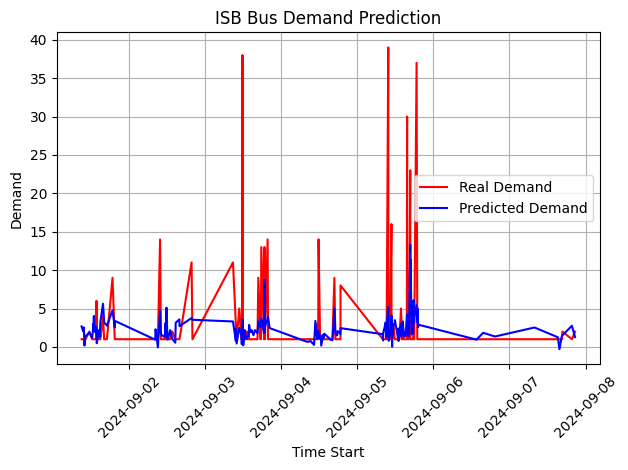

MAE: 2.401352459462462


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
19,1,D1,UTown,2024-09-01 09:00:00,Monday,0,0,9,0,2.671160
52,1,D1,UTown,2024-09-01 09:29:00,Monday,0,0,9,29,2.037977
67,1,D1,UTown,2024-09-01 09:41:00,Monday,0,1,9,41,2.190022
69,1,D1,UTown,2024-09-01 09:43:00,Monday,0,1,9,43,2.546425
97,1,D1,UTown,2024-09-01 09:54:00,Monday,0,1,9,54,0.180160
...,...,...,...,...,...,...,...,...,...,...
5597,1,D1,UTown,2024-09-07 15:46:00,Sunday,1,1,15,46,-0.294939
5609,1,D1,UTown,2024-09-07 16:31:00,Sunday,1,1,16,31,1.378558
5611,2,D1,UTown,2024-09-07 16:42:00,Sunday,1,1,16,42,1.508106
5676,1,D1,UTown,2024-09-07 19:42:00,Sunday,1,0,19,42,2.752468


In [138]:
d1 = df[(df['ISB_Service'] == 'D1')]


d1_UTown = d1[(d1['bus_stop_board'] == 'UTown')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(d1_UTown['time_start'], d1_UTown['count'], color='red', label='Real Demand')
plt.plot(d1_UTown['time_start'], d1_UTown['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

from sklearn.metrics import mean_absolute_error
mae_d1 = mean_absolute_error(d1_UTown['count'], d1_UTown['predicted_count'])
print("MAE:", mae_d1)

d1_UTown


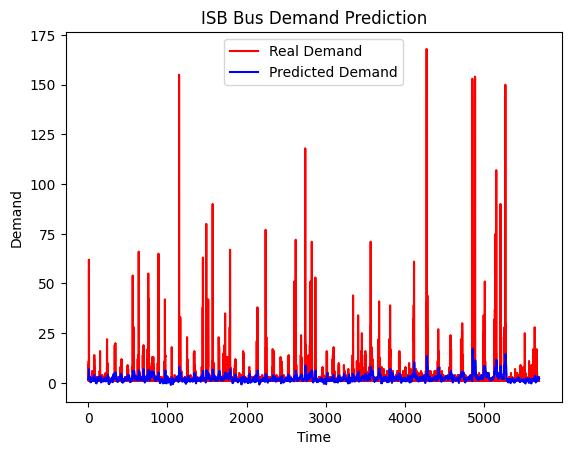

MAE: 2.300816827564428
2.300816827564428


In [139]:
plt.plot(original, color = 'red', label = 'Real Demand')
plt.plot(pred, color = 'blue', label = 'Predicted Demand')
plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(original, pred)
print("MAE:", mae)
print(mae)


In [140]:
import pandas as pd
from datetime import datetime, timedelta

columns = ['count', 'ISB_Service', 'bus_stop_board', 'day_of_the_week', 'is_weekend', 'is_peak', 'hour', 'minute']

base_df = pd.DataFrame(columns = columns)

dates = pd.date_range("2024-09-15", "2024-09-21", freq="D")

# Initialize an empty list to store all the datetime rows
datetime_rows = []

# Loop through each date
for date in dates:
    # Set the start and end times for each day
    start_time = datetime.combine(date, datetime.min.time()) + timedelta(hours=7)  # 7:00 AM
    end_time = datetime.combine(date, datetime.min.time()) + timedelta(hours=23)  # 11:00 PM

    # Initialize the current time for the loop
    current_time = start_time

    # Loop through every 5 minutes for the current date
    while current_time <= end_time:
        # Append the current time to the list in the format YYYY-MM-DD HH:MM:SS
        datetime_rows.append(current_time.strftime("%Y-%m-%d %H:%M:%S"))
        
        # Increment the current time by 5 minutes
        current_time += timedelta(minutes=5)

# Create a DataFrame with the datetime values in a column
time_df = pd.DataFrame(datetime_rows, columns=["DateTime"])

base_df['time_start'] = time_df

base_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:05:00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:10:00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:15:00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:20:00
...,...,...,...,...,...,...,...,...,...
1346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:40:00
1347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:45:00
1348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:50:00
1349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:55:00


In [141]:

A1_bus = ['KR Bus Terminal', 'LT13', 'AS5', 'BIZ2', 'Opp TCOMS', 'PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'YIH', 'CLB', 'KR Bus Terminal']
A2_bus = ['KR Bus Terminal', 'IT', 'Opp YIH', 'Museum', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer', 'TCOMS', 'Opp HSSML', 'Opp NUSS', 'Ventus', 'KR Bus Terminal']
D1_bus = ['COM3', 'Opp HSSML', 'Opp NUSS', 'Ventus', 'IT', 'Opp YIH', 'Museum', 'UTown', 'YIH', 'CLB', 'LT13', 'AS5', 'BIZ2', 'COM3']
D2_bus = ['COM3', 'Opp TCOMS', 'PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'Museum', 'UTown', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer', 'TCOMS', 'COM3']
BTC_bus = ['Oei Tiong Ham Building (BTC)', 'Botanic Gardens MRT (BTC)', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'UTown', 'Raffles Hall', 'Kent Vale', 'Museum', 'YIH', 'CLB', 'LT13', 'AS5', 'BIZ2', 'PGP Terminal', 'College Green (BTC)', 'Oei Tiong Ham Building (BTC)']
E_bus = ['UTown', 'Raffles Hall', 'Kent Vale', 'EA', 'SDE3', 'IT', 'Opp YIH', 'UTown']
K_bus = ['PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'YIH', 'CLB', 'Opp SDE3', 'The Japanese Primary School', 'Kent Vale', 'Museum', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer']
L_bus = ['Oei Tiong Ham Building (BTC)', 'Botanic Gardents MRT (BTC)', 'College Green (BTC)', 'Oei Tiong Ham Building (BTC)']

bus_routes = {'A1':A1_bus, 'A2':A2_bus, 'D1':D1_bus, 'D2':D2_bus, 'BTC (Bukit Timah Campus)':BTC_bus, 'E':E_bus, 'K':K_bus, 'L':L_bus}

# Initialize an empty list to store the new rows
new_rows = []

# Loop through each bus route and fill the data
for bus, stops in bus_routes.items():
    for stop in stops:
        # Create a new DataFrame based on base_df
        temp_df = base_df.copy()
        # Set ISB_Service and bus_stop_board values
        temp_df['ISB_Service'] = bus
        temp_df['bus_stop_board'] = stop
        # Append each row as a dictionary to the list
        new_rows.extend(temp_df.to_dict(orient='records'))


future_df = pd.DataFrame()
# Concatenate all the new rows with future_df at once
future_df = pd.concat([future_df, pd.DataFrame(new_rows)], ignore_index=True)


future_df[1350:1400]

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start
1350,NaN,A1,KR Bus Terminal,NaN,NaN,NaN,NaN,NaN,2024-09-21 23:00:00
1351,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:00:00
1352,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:05:00
1353,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:10:00
1354,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:15:00
1355,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:20:00
1356,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:25:00
1357,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:30:00
1358,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:35:00
1359,NaN,A1,LT13,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:40:00


In [142]:

future_df['time_start'] = pd.to_datetime(future_df['time_start'])

def assign_dayofweek(row):
    date = str(row['time_start'].date())

    if date == '2024-09-15':
        return 'Monday'  
    elif date == '2024-09-16':
        return 'Tuesdays'
    elif date == '2024-09-17':
        return 'Wednesdays'
    elif date == '2024-09-18':
        return 'Thursdays'
    elif date == '2024-09-19':
        return 'Fridays'
    elif date == '2024-09-20':
        return 'Saturday'
    else:
        return 'Sunday' 



# Apply the function to create a new date column
future_df['day_of_the_week'] = future_df.apply(assign_dayofweek, axis=1)
future_df['is_weekend'] = future_df.apply(assign_weekend, axis=1)
future_df['is_peak'] = future_df.apply(assign_peak, axis=1)
future_df['hour'] = future_df.apply(assign_hour, axis=1)
future_df['minute'] = future_df.apply(assign_minute, axis=1)



future_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start
0,NaN,A1,KR Bus Terminal,Monday,0,0,7,0,2024-09-15 07:00:00
1,NaN,A1,KR Bus Terminal,Monday,0,0,7,5,2024-09-15 07:05:00
2,NaN,A1,KR Bus Terminal,Monday,0,0,7,10,2024-09-15 07:10:00
3,NaN,A1,KR Bus Terminal,Monday,0,0,7,15,2024-09-15 07:15:00
4,NaN,A1,KR Bus Terminal,Monday,0,0,7,20,2024-09-15 07:20:00
...,...,...,...,...,...,...,...,...,...
139148,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,40,2024-09-21 22:40:00
139149,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,45,2024-09-21 22:45:00
139150,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,50,2024-09-21 22:50:00
139151,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,55,2024-09-21 22:55:00


In [143]:
old_df = grouped_data

label_encoder_bsb_f = preprocessing.LabelEncoder() 
label_encoder_ISBS_f = preprocessing.LabelEncoder() 
label_encoder_dotw_f = preprocessing.LabelEncoder()


old_df['bus_stop_board']= label_encoder_bsb_f.fit_transform(old_df['bus_stop_board']) 
future_df['bus_stop_board']= label_encoder_bsb_f.fit_transform(future_df['bus_stop_board'])  
 
old_df['day_of_the_week']= label_encoder_dotw_f.fit_transform(old_df['day_of_the_week']) 
future_df['day_of_the_week']= label_encoder_dotw_f.fit_transform(future_df['day_of_the_week']) 

old_df['ISB_Service']= label_encoder_ISBS_f.fit_transform(old_df['ISB_Service'])
future_df['ISB_Service']= label_encoder_ISBS_f.fit_transform(future_df['ISB_Service'])


future_df = future_df.sort_values(by='time_start')
full_df = pd.concat([old_df, future_df])
full_df = full_df.drop('time_start', axis=1)
full_df_scaled = scaler.fit_transform(full_df)

full_df_scaled

array([[0.0028169 , 0.57142857, 0.17142857, ..., 0.        , 0.        ,
        0.76271186],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.77966102],
       [0.0084507 , 0.57142857, 0.34285714, ..., 0.        , 0.        ,
        0.77966102],
       ...,
       [       nan, 0.85714286, 0.85714286, ..., 0.        , 1.        ,
        0.        ],
       [       nan, 0.        , 0.02857143, ..., 0.        , 1.        ,
        0.        ],
       [       nan, 1.        , 0.42857143, ..., 0.        , 1.        ,
        0.        ]])

In [144]:
#old_df_scaled = pd.DataFrame(old_df_scaled)
#future_df_scaled = pd.DataFrame(future_df_scaled)

# Concatenate old_df_scaled and future_df_scaled
#full_df = pd.concat([old_df_scaled, future_df_scaled])

full_df_scaled.shape

(158242, 8)

In [152]:
# Get the scaled values as an array
full_df_scaled_array = full_df.values
all_data = []
time_step = 30

# Handle NaN in the target column before processing
# Replace NaN values in the 'counts' column (first column) with some placeholder like 0
full_df_scaled_array[:, 0] = np.nan_to_num(full_df_scaled_array[:, 0], nan=0)

# Prepare the input data (X) for the LSTM model
# We'll create sequences from both historical and future data
X = [full_df_scaled_array[i - time_step:i, :] for i in range(time_step, len(full_df_scaled_array))]
X = np.array(X)

# Check if there are still NaN values in features
if np.any(np.isnan(X)):
    print("NaN found in X. Proceeding with replacements.")

# Make predictions in batch
predictions = best_model.predict(X)

# Flatten predictions to ensure they match the shape of the counts column
predictions = predictions.flatten()

# Store predictions in `all_data` for later use (if needed)
all_data.extend(predictions)

# Update the 'counts' column (first column) with the predictions for the future data
full_df.iloc[time_step:, 0] = predictions  # Replace NaN values in the 'counts' column with predictions


9889/9889 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step


In [178]:
future_predicted_df = full_df[19089:]

future_predicted_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute
0,0.025126,0,9,1,0,0,7,0
85113,0.034397,2,32,1,0,0,7,0
21616,0.028947,1,14,1,0,0,7,0
54040,0.034471,3,5,1,0,0,7,0
133749,0.038153,7,15,1,0,0,7,0
...,...,...,...,...,...,...,...,...
75655,0.056365,4,29,3,1,0,23,0
63496,0.053957,4,33,3,1,0,23,0
124291,0.052488,6,30,3,1,0,23,0
5403,0.049239,0,1,3,1,0,23,0


In [ ]:
#full_df_scaled_array = full_df_scaled
#all_data=[]
#time_step = 30

#for i in range(time_step, len(full_df_scaled_array)):
    #data_x = []
    #data_x.append(
    #full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    #data_x = np.array(data_x)
    #prediction = best_model.predict(data_x)
    #all_data.append(prediction)
    #full_df.iloc[i,0] = prediction



In [182]:
new_array = np.array(future_predicted_df['count'])
new_array = new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,8, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),8)))[:,0]
print(y_pred_future_30_days)

future_df['predicted_count'] = y_pred_future_30_days

future_df

[ 9.91985396 13.21101781 11.27632896 ... 19.63336667 18.4797651
 16.91335332]


,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
0,NaN,0,9,1,0,0,7,0,2024-09-15 07:00:00,9.919854
85113,NaN,2,32,1,0,0,7,0,2024-09-15 07:00:00,13.211018
21616,NaN,1,14,1,0,0,7,0,2024-09-15 07:00:00,11.276329
54040,NaN,3,5,1,0,0,7,0,2024-09-15 07:00:00,13.237241
133749,NaN,7,15,1,0,0,7,0,2024-09-15 07:00:00,14.544193
...,...,...,...,...,...,...,...,...,...,...
75655,NaN,4,29,3,1,0,23,0,2024-09-21 23:00:00,21.009420
63496,NaN,4,33,3,1,0,23,0,2024-09-21 23:00:00,20.154881
124291,NaN,6,30,3,1,0,23,0,2024-09-21 23:00:00,19.633367
5403,NaN,0,1,3,1,0,23,0,2024-09-21 23:00:00,18.479765


In [183]:

# Reverse the label encoding for the categorical columns
future_df['ISB_Service'] = future_df['ISB_Service'].astype(int)
future_df['day_of_the_week'] = future_df['day_of_the_week'].astype(int)
future_df['bus_stop_board'] = future_df['bus_stop_board'].astype(int)

# Apply the label encoders to unencode the labels (inverse transform)
future_df['ISB_Service'] = label_encoder_ISBS_f.inverse_transform(future_df['ISB_Service'])
future_df['bus_stop_board'] = label_encoder_bsb_f.inverse_transform(future_df['bus_stop_board'])
future_df['day_of_the_week'] = label_encoder_dotw_f.inverse_transform(future_df['day_of_the_week'])

future_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
0,NaN,A1,KR Bus Terminal,Monday,0,0,7,0,2024-09-15 07:00:00,9.919854
85113,NaN,BTC (Bukit Timah Campus),UTown,Monday,0,0,7,0,2024-09-15 07:00:00,13.211018
21616,NaN,A2,Museum,Monday,0,0,7,0,2024-09-15 07:00:00,11.276329
54040,NaN,D1,COM3,Monday,0,0,7,0,2024-09-15 07:00:00,13.237241
133749,NaN,L,Oei Tiong Ham Building (BTC),Monday,0,0,7,0,2024-09-15 07:00:00,14.544193
...,...,...,...,...,...,...,...,...,...,...
75655,NaN,D2,TCOMS,Sunday,1,0,23,0,2024-09-21 23:00:00,21.009420
63496,NaN,D2,University Hall,Sunday,1,0,23,0,2024-09-21 23:00:00,20.154881
124291,NaN,K,The Japanese Primary School,Sunday,1,0,23,0,2024-09-21 23:00:00,19.633367
5403,NaN,A1,BIZ2,Sunday,1,0,23,0,2024-09-21 23:00:00,18.479765


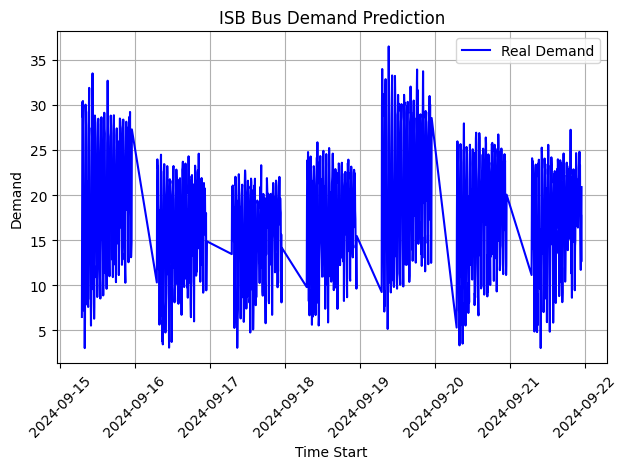

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
21616,NaN,A2,Museum,Monday,0,0,7,0,2024-09-15 07:00:00,11.276329
31073,NaN,A2,Opp HSSML,Monday,0,0,7,0,2024-09-15 07:00:00,11.364924
33775,NaN,A2,Ventus,Monday,0,0,7,0,2024-09-15 07:00:00,9.979896
35126,NaN,A2,KR Bus Terminal,Monday,0,0,7,0,2024-09-15 07:00:00,6.912539
18914,NaN,A2,IT,Monday,0,0,7,0,2024-09-15 07:00:00,7.272735
...,...,...,...,...,...,...,...,...,...,...
36476,NaN,A2,KR Bus Terminal,Sunday,1,0,23,0,2024-09-21 23:00:00,18.866249
28370,NaN,A2,Opp KR MRT,Sunday,1,0,23,0,2024-09-21 23:00:00,20.877524
22966,NaN,A2,Museum,Sunday,1,0,23,0,2024-09-21 23:00:00,22.304085
31072,NaN,A2,TCOMS,Sunday,1,0,23,0,2024-09-21 23:00:00,20.446187


In [186]:
a2_future = future_df[(future_df['ISB_Service'] == 'A2')]
a2_Opp_KR_MRT_future = a2_future[(a2_future['bus_stop_board'] == 'Opp KR MRT')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(a2_Opp_KR_MRT_future['time_start'], a2_Opp_KR_MRT_future['predicted_count'], color='blue', label='Real Demand')
#plt.plot(a2_Opp_KR_MRT_future['time_start'], a2_Opp_KR_MRT_future['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

a2_future

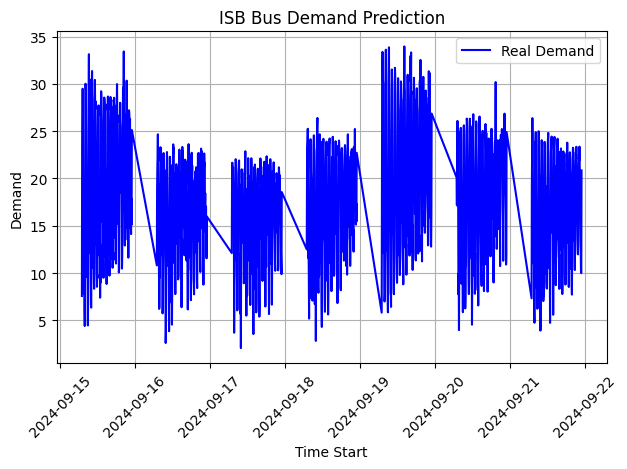

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
21616,NaN,A2,Museum,Monday,0,0,7,0,2024-09-15 07:00:00,11.276329
31073,NaN,A2,Opp HSSML,Monday,0,0,7,0,2024-09-15 07:00:00,11.364924
33775,NaN,A2,Ventus,Monday,0,0,7,0,2024-09-15 07:00:00,9.979896
35126,NaN,A2,KR Bus Terminal,Monday,0,0,7,0,2024-09-15 07:00:00,6.912539
18914,NaN,A2,IT,Monday,0,0,7,0,2024-09-15 07:00:00,7.272735
...,...,...,...,...,...,...,...,...,...,...
36476,NaN,A2,KR Bus Terminal,Sunday,1,0,23,0,2024-09-21 23:00:00,18.866249
28370,NaN,A2,Opp KR MRT,Sunday,1,0,23,0,2024-09-21 23:00:00,20.877524
22966,NaN,A2,Museum,Sunday,1,0,23,0,2024-09-21 23:00:00,22.304085
31072,NaN,A2,TCOMS,Sunday,1,0,23,0,2024-09-21 23:00:00,20.446187


In [188]:
d2_future = future_df[(future_df['ISB_Service'] == 'D2')]
d2_KR_MRT_future = d2_future[(d2_future['bus_stop_board'] == 'KR MRT')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(d2_KR_MRT_future['time_start'], d2_KR_MRT_future['predicted_count'], color='blue', label='Real Demand')
#plt.plot(a2_Opp_KR_MRT_future['time_start'], a2_Opp_KR_MRT_future['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

a2_future

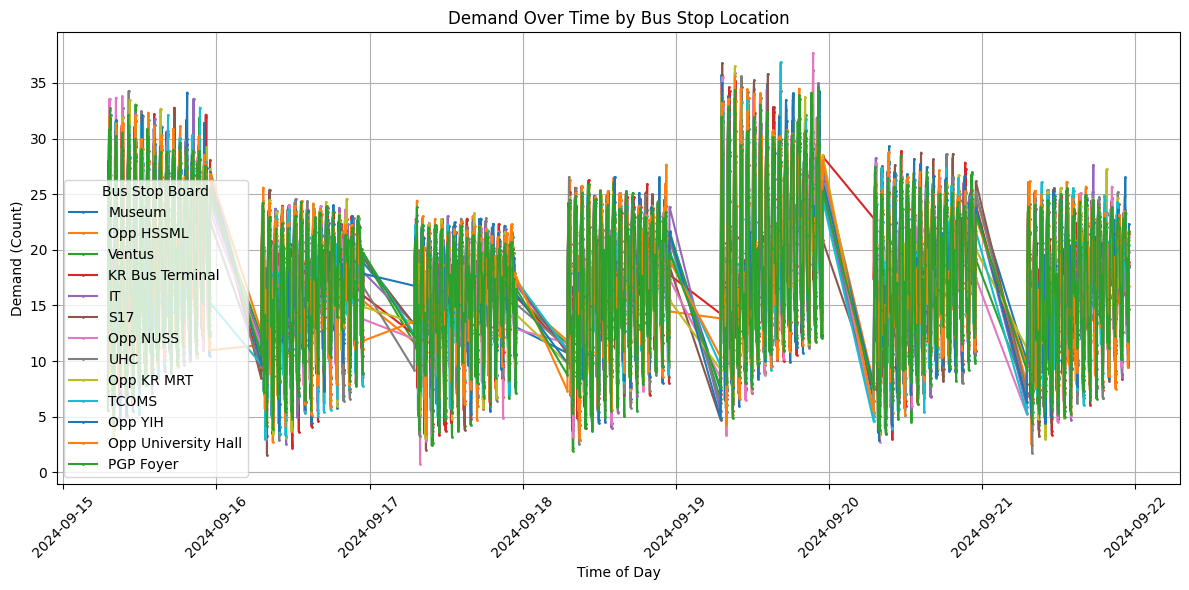

In [187]:
# Plotting
plt.figure(figsize=(12, 6))
for bus_stop_board in a2_future['bus_stop_board'].unique():
    subset = a2_future[a2_future['bus_stop_board'] == bus_stop_board]
    plt.plot(subset['time_start'], subset['predicted_count'], label = bus_stop_board, marker='o', markersize=1)

# Configure plot labels and title
plt.title('Demand Over Time by Bus Stop Location')
plt.xlabel('Time of Day')
plt.ylabel('Demand (Count)')
plt.xticks(rotation = 45)
plt.legend(title='Bus Stop Board')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
